<table width="100%">
  <tr>
    <th>
    <h1><b> &nbsp; Soheil Sedghi </b></h1>  </br>
    <h3>Part Softwar Group</h3> 1403/09/14
    <th>
    <th><h1>InsightFace <br/> ArcFace <br/> API </h1><th>
    <th><img src="https://avatars.githubusercontent.com/u/40862552?s=200&v=4"></th>
  </tr>
</table>

# **server:**

1. Model Initialization:

  Loads and initializes pre-trained models (buffalo_s, buffalo_l) for subsequent client requests.
  the shape of inputs set to (480*480) as most of users do. The threshould of face recognition is set to 0.5 as default. It was better to change this value because some images in CPLFW cannot be recognized by the model. The treshould value for pair recognition is set to 0.24.

2. Flask Server Setup:

  Deploys a Flask server on a Colab thread to handle HTTP POST requests.

3. Request Handling:

  Upon receiving a client request:

  * decode two images using base64 and gets selected model from the request payload.
  * Computes embeddings for both images using the specified pre-trained model.
  * Calculates the cosine similarity between the computed embeddings.
  
  **Cosine Similarity(A, B) = (A · B) / (||A|| * ||B||)**

  * Compares the calculated similarity to a predefined threshold.
  * Returns a response indicating a match (True) if the similarity exceeds the threshold, or a mismatch (False) otherwise. The response is in JSON format.

# **client:**

1. download Datasets (LFW, CALFW and CPLFW) and extracting pairs from specific pair file.
2. load each pair, encode using base64 and send as a http POST request containing name of selected model in JSON format.
3. get response from server and store in a variable.
4. calculate accuracy.

**Accuracy = (TP + TN) / (TP + TN + FP + FN)**

Where:

TP (True Positive): The system correctly identifies two images as belonging to the same person.

TN (True Negative): The system correctly identifies two images as belonging to different people.

FP (False Positive): The system incorrectly identifies two images of different people as belonging to the same person.

FN (False Negative): The system incorrectly identifies two images of the same person as belonging to different people.


FMR (False Match Rate)

FMR measures the likelihood that the system will incorrectly identify two images of different people as belonging to the same person. It's the ratio of false positives to the total number of impostor pairs.

Formula:

**FMR = FP / (FP + TN)**

FNMR (False Non-Match Rate)

FNMR measures the likelihood that the system will incorrectly identify two images of the same person as belonging to different people. It's the ratio of false negatives to the total number of same pairs.

Formula:

**FNMR = FN / (FN + TP)**

# **######################----SERVER----######################**

## install and import libraries


In [ ]:
!pip install flask
!pip install -U insightface
!pip install onnxruntime --q
!pip install onnxruntime-gpu
## server ##
import socket
from flask import Flask, jsonify, make_response, request, Response
import threading


## face recognition ##
from insightface.app import FaceAnalysis
from torch.nn.functional import cosine_similarity
import cv2
import numpy as np
import os
import json
from torch import tensor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 9.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 92.1 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp310-cp310-linux_x86_64.whl size=1055397 sha256=30779f8c733eb4784f5ebba3f246ba99047f44d137c3f45fc5ae5a5f56cbbc52
  Stored in directory: /root/.cache/pip/wheels/e3/d0/80/e3773fb8b6d1cca87ea1d33d9b1f20a223a6493c896da249b5
Successfully built insightface
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 4.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## run server

Because of using colab the ip is needed to make a server thread.

In [ ]:
ip = socket.gethostbyname(socket.gethostname())
print(ip)
app = Flask("Face Recognition")


172.28.0.12


### Server Functions
1- load model \\
2- wait for requests \\
3- predict match or non-match

In [ ]:
class Model:
  def __init__(self, name):
    if name == "buffalo_l":
      self.app = FaceAnalysis(name="buffalo_l",
                 providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

    elif name == "buffalo_s":
      self.app = FaceAnalysis(name="buffalo_s", providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

    self.app.prepare(ctx_id=0, det_size=(480, 480))

  def embedding(self,image):
    face = self.app.get(image)
    return face[0].embedding
  def compare_faces( self, embd1 , embd2 , threshould = 0.5 ):
    similarity = cosine_similarity(tensor(embd1) , tensor(embd2),dim=0).item()
    if similarity > threshould:
      return True
    else:
      return False

  def prepare_image(self,image):
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    return image

  def evaluate_model(self,image1,image2,threshould=0.24):
    image1 = self.prepare_image(image1)
    image2 = self.prepare_image(image2)
    embd1 = self.embedding(image1)
    embd2 = self.embedding(image2)
    return self.compare_faces(embd1,embd2,threshould)




### Call server

In [ ]:
# load model
buffalo_l = Model("buffalo_l")
buffalo_s = Model("buffalo_s")

def decode_img(data,name):
  #  read encoded image
  imageS = base64.b64decode(data[name])
  #  convert binary data to numpy array
  nparr = np.fromstring(imageS, np.uint8)
  #  let opencv decode image to correct format
  img = cv2.imdecode(nparr, cv2.IMREAD_ANYCOLOR);
  return img

# prediction
@app.route("/predict", methods=["POST"])
def predict():
  try:
    data = request.get_json()
    image1 = decode_img(data,"img1")
    image2 = decode_img(data,"img2")
    selected_model = data["model"]
    if selected_model == "buffalo_l":
      model = buffalo_l
    elif selected_model == "buffalo_s":
      model = buffalo_s
    else:
      return Response(json.dumps({'message': 'unknown model'}), status=400)
    answer = model.evaluate_model(image1,image2)
    return Response(json.dumps({'message': answer}), status=200)
  except Exception as e:
    return Response(json.dumps({'message': str(e)}), status=400)


download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:04<00:00, 59969.97KB/s]


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (480, 480)
download_pat

100%|██████████| 124617/124617 [00:03<00:00, 39986.30KB/s]


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_s/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_s/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_s/det_500m.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_s/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_s/w600k_mbf.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (480, 480)


### Run Server

In [ ]:
threading.Thread(target=app.run, kwargs={'host':ip,'port':6008}).start()

 * Serving Flask app 'Face Recognition'


# **######################----Client----:######################**


## install and import libraries


In [ ]:
!pip install gdown # download
import os
import gdown
import base64
from zipfile import ZipFile
import requests
import cv2
import numpy as np
import tarfile
import urllib.request
from IPython.display import clear_output



 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://172.28.0.12:6008
INFO:werkzeug:Press CTRL+C to quit



## LFW Dataset
**pairs.txt format:**

The pairs.txt file is formatted as follows: The top line gives the
number of sets followed by the number of matched pairs per set (equal
to the number of mismatched pairs per set).  The next 300 lines give
the matched pairs in the following format:

`name   n1   n2`

which means the matched pair consists of the n1 and n2 images for the
person with the given name.  For instance,

`George_W_Bush   10   24`

would mean that the pair consists of images George_W_Bush_0010.jpg and George_W_Bush_0024.jpg.

The following 300 lines give the mismatched pairs in the following format:

`name1   n1   name2   n2`

which means the mismatched  pair consists of  the n1 image  of person
name1 and the n2 image of person name2.  For instance,

`George_W_Bush   12   John_Kerry   8`

would mean that the pair consists of images George_W_Bush_0012.jpg and
John_Kery_0008.jpg.

This procedure is then repeated 9 more times to give the pairs for the
next 9 sets.

In [ ]:
class LFW:
  def __init__(self):
    self.dataset_name = "LFW"
    self.download_dataset()
    self.data_path = "lfw"
    self.pairs_file_path = os.path.join(self.data_path,"pairs.txt")
    self.pairs = self.load_pairs()


  # download Dataset
  def download_dataset(self):
    try:
      datafile_name = "lfw.tgz"
      pairfile_name = "pairs.txt"
      url_data = "http://vis-www.cs.umass.edu/lfw/lfw.tgz"
      url_pair = "http://vis-www.cs.umass.edu/lfw/pairs.txt"
      if  not os.path.isdir("lfw"):
        #Verify if the dataset has been downloaded and extracted previously.
        if not os.path.isfile(datafile_name):
          if not os.path.isdir("lfw"):
            print("downloading lfw dataset...")
            urllib.request.urlretrieve(url_data, datafile_name)
            with tarfile.open(datafile_name) as file:
              print("extracting...")
              # extracting file
              file.extractall()
      if not os.path.isfile(os.path.join("lfw", pairfile_name)):

        urllib.request.urlretrieve(url_pair, pairfile_name)
        # move to /lfw
        os.rename(pairfile_name , os.path.join("lfw",pairfile_name))

    except Exception as e:
      raise RuntimeError("Error loading pairs: {error}".format(error=e))

  def load_pairs(self):
    try:
      pairs = []
      with open(self.pairs_file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
          sp_line = line.strip().split() #3 for similar images
          pair_dir = lambda name , n : os.path.join(name,"{name}_{n:04d}.jpg".format(name = name, n=int(n)))
          if len(sp_line) == 3: # for matched
            name , n1 , n2 = sp_line
            p1 = pair_dir(name,n1)
            p2 = pair_dir(name,n2)
            pairs.append( (p1,p2, True) )
          elif len(sp_line) == 4: # for mismatched
            name1 , n1 , name2 , n2 = sp_line
            p1 = pair_dir(name1,n1)
            p2 = pair_dir(name2,n2)
            pairs.append( (p1,p2, False) )
      return pairs
    except Exception as e:
      raise RuntimeError("Error loading pairs: {error}".format(error=e))
  def __len__(self):
    return len(self.pairs)
  def __getitem__(self,index):
    pair = self.pairs[index]
    image_path1 = os.path.join(self.data_path,pair[0])
    image_path2 = os.path.join(self.data_path,pair[1])
    label = pair[2]
    # image1 = cv2.cvtColor(cv2.imread(image_path1), cv2.COLOR_RGB2BGR)
    # image2 = cv2.cvtColor(cv2.imread(image_path2), cv2.COLOR_RGB2BGR)
    image1 = cv2.imread(image_path1)
    image2 =cv2.imread(image_path2)
    return image1,image2,label

example LFW

downloading lfw dataset...
extracting...
[('Jack_Straw/Jack_Straw_0025.jpg', 'Jack_Straw/Jack_Straw_0028.jpg', True), ('Lleyton_Hewitt/Lleyton_Hewitt_0018.jpg', 'Lleyton_Hewitt/Lleyton_Hewitt_0037.jpg', True), ('Kathie_Louise_Saunders/Kathie_Louise_Saunders_0001.jpg', 'Roberto_Lavagna/Roberto_Lavagna_0001.jpg', False), ('Clive_Woodward/Clive_Woodward_0001.jpg', 'Douglas_Faneuil/Douglas_Faneuil_0001.jpg', False), ('Michael_Caine/Michael_Caine_0001.jpg', 'Michael_Caine/Michael_Caine_0002.jpg', True), ('Sergey_Lavrov/Sergey_Lavrov_0001.jpg', 'Sergey_Lavrov/Sergey_Lavrov_0006.jpg', True), ('Roger_Cook/Roger_Cook_0001.jpg', 'Wilbert_Foy/Wilbert_Foy_0001.jpg', False), ('Miguel_Estrada/Miguel_Estrada_0001.jpg', 'Miguel_Estrada/Miguel_Estrada_0002.jpg', True), ('Frank_Griswold/Frank_Griswold_0001.jpg', 'Frank_Griswold/Frank_Griswold_0002.jpg', True), ('Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0002.jpg', 'Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0009.jpg', True)]
[True, Tr

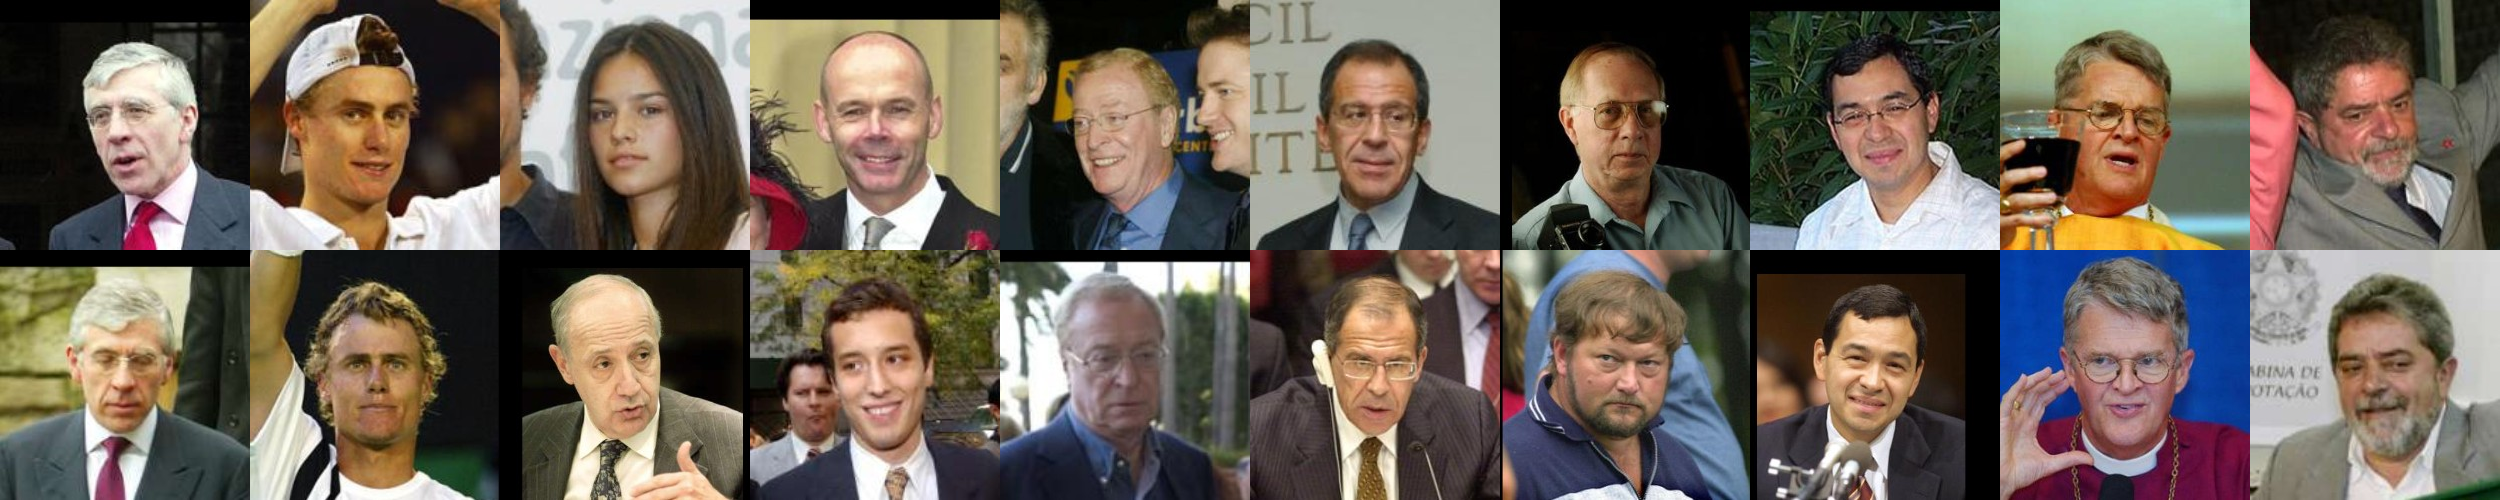

In [ ]:
LFW_loader = LFW()
image_num = 10
# concatenate image Horizontally
rand_select = np.random.randint(0, len(LFW_loader)-1, image_num)
Hori = [np.concatenate((LFW_loader[i][0] , LFW_loader[i][1]), axis=0) for i in rand_select]
Verti = Hori[0]
for i in range(1,image_num):
  Verti = np.concatenate( (Verti,Hori[i]) , axis = 1 )
from google.colab.patches import cv2_imshow
print([LFW_loader.pairs[i] for i in rand_select])
print([LFW_loader[i][2] for i in rand_select])
cv2_imshow(Verti)

## C*LFW - parent class for CALFW and CPLFW
Each dataset has 6000 images with size (224 * 224 * 3).


These two datasets use same method to show the paires in files so I use a method for both.

```
Tabare_Vazquez_0001.jpg 4

Tabare_Vazquez_0004.jpg 4
```
means Tabare_Vazquez_0001.jpg and Tabare_Vazquez_0004.jpg are for a same person. Non zero label shows match.

example of non-match:
```
Laurence_Tribe_0001.jpg 0
Lyle_Vanclief_0001.jpg 0
```



In [ ]:
## parent class for CALFW and CPLFW
class C_AP_LFW:
  def __init__(self,dataset_name,url):
    # download data_set
    self.download_dataset(dataset_name,url)
    # dataset directory
    self.dataset_path = os.path.join("{dataset}".format(dataset = dataset_name.lower()))
    # pair file .txt
    self.pairs_file_name = "pairs_{dataset_name}.txt".format(dataset_name = dataset_name.upper())
    self.pairs_file_path = os.path.join(self.dataset_path,self.pairs_file_name)
    # pairs load
    self.pairs = self.load_pairs()
    # images directory
    self.images_file_path = os.path.join(self.dataset_path, "aligned images" )

  ## extract pairs from txt file
  def load_pairs(self):
    pairs = []
    try:
      pairs = []
      with open(self.pairs_file_path, 'r') as file:
        lines = file.readlines()
        for i in range(0,len(lines),2):
          sp_line1 = lines[i].strip().split(' ')
          sp_line2 = lines[i+1].strip().split(' ')
          pairs.append((sp_line1[0],sp_line2[0], int(sp_line1[1]) != 0 ))
      return pairs
    except Exception as e:
      raise RuntimeError("Error loading pairs: {error}".format(error=e))

  # download Dataset
  def download_dataset(self,dataset_name,url):
    try:
      if  not os.path.isdir(dataset_name.lower()):
        zip_file = "{}.zip".format(dataset_name.upper())
        if not os.path.isfile(zip_file):
          gdown.download(url, zip_file, quiet=False,fuzzy=True)
        with ZipFile(zip_file, 'r') as zObject:
          zObject.extractall()

    except Exception as e:
      raise RuntimeError("Error loading pairs: {error}".format(error=e))

  def __getitem__(self,index):
    pair = self.pairs[index]
    # get image path
    image_path1 = os.path.join(self.images_file_path,pair[0])
    image_path2 = os.path.join(self.images_file_path,pair[1])
    label = pair[2]
    # read images
    image1 = cv2.imread(image_path1)
    image2 = cv2.imread(image_path2)
    return image1,image2,label

  def __len__(self):
    return len(self.pairs)




## CALFW

In [ ]:
class CALFW(C_AP_LFW):
  def __init__(self):
    super().__init__("CALFW","https://drive.google.com/file/d/1_cYgy7VFCy6JqkR8EvOxCVS02jHN1ozm/view?usp=sharing")
    self.dataset_name = "CALFW"


## CALFW Samples

Downloading...
From (original): https://drive.google.com/uc?id=1_cYgy7VFCy6JqkR8EvOxCVS02jHN1ozm
From (redirected): https://drive.google.com/uc?id=1_cYgy7VFCy6JqkR8EvOxCVS02jHN1ozm&confirm=t&uuid=291bcfca-c934-4ccc-87cc-6a033a158a83
To: /content/CALFW.zip
100%|██████████| 296M/296M [00:07<00:00, 40.4MB/s]


[('Corinna_Harfouch_0002.jpg', 'Laura_Linney_0002.jpg', False), ('Tammy_Lynn_Michaels_0001.jpg', 'Tammy_Lynn_Michaels_0002.jpg', True), ('Michelle_Branch_0001.jpg', 'Michelle_Branch_0002.jpg', True), ('Celine_Dion_0004.jpg', 'Lisa_Marie_Presley_0002.jpg', False), ('Imran_Khan_0004.jpg', 'Steven_Seagal_0002.jpg', False), ('John_Cornyn_0001.jpg', 'John_Cornyn_0002.jpg', True), ('Abel_Pacheco_0004.jpg', 'Trent_Lott_0003.jpg', False), ('Jennifer_Garner_0004.jpg', 'Maria_Callas_0002.jpg', False), ('Bill_Callahan_0001.jpg', 'Bill_Callahan_0004.jpg', True), ('Luiz_Inacio_Lula_da_Silva_0001.jpg', 'Luiz_Inacio_Lula_da_Silva_0004.jpg', True)]
[False, True, True, False, False, True, False, False, True, True]


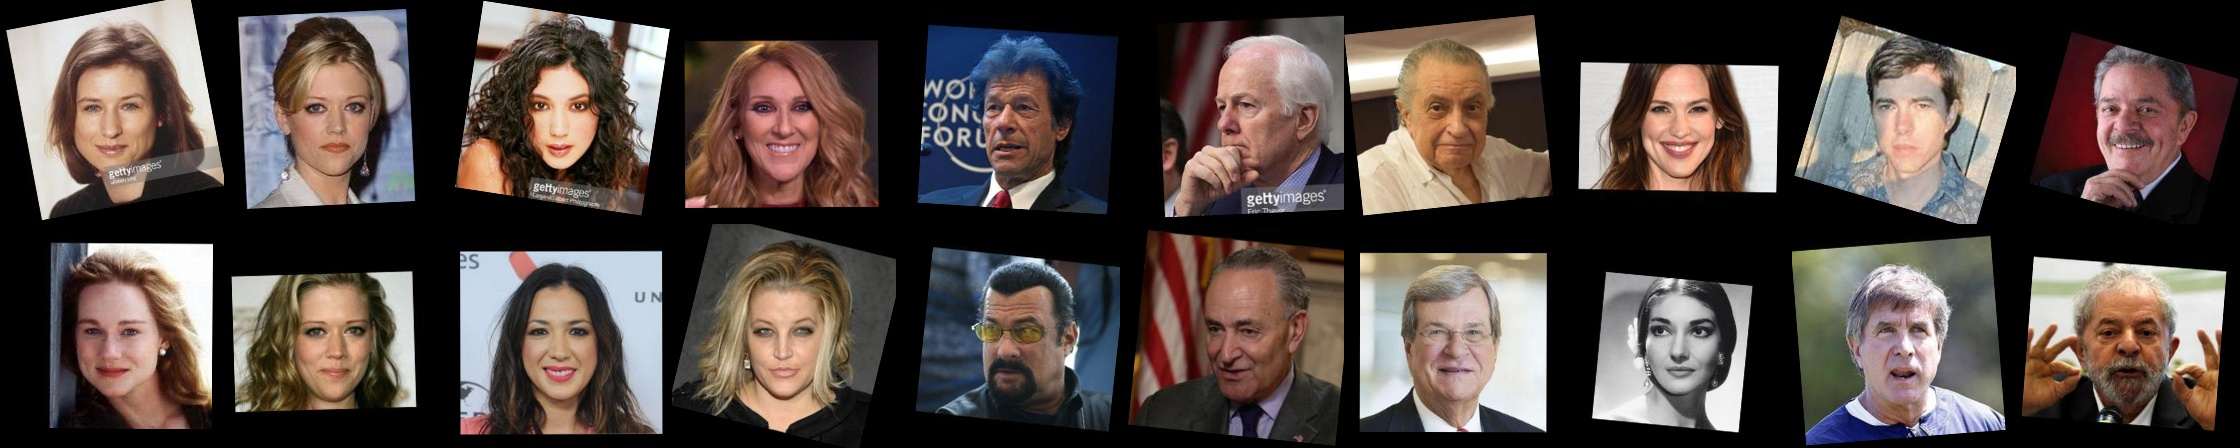

In [ ]:
CALFW_loader = CALFW()
image_num = 10

# concatenate image Horizontally
rand_select = np.random.randint(0, len(CALFW_loader)-1, image_num)
Hori = [np.concatenate((CALFW_loader[i][0] , CALFW_loader[i][1]), axis=0) for i in rand_select]
Verti = Hori[0]
for i in range(1,image_num):
  Verti = np.concatenate( (Verti,Hori[i]) , axis = 1 )
from google.colab.patches import cv2_imshow
print([CALFW_loader.pairs[i] for i in rand_select])
print([CALFW_loader[i][2] for i in rand_select])
cv2_imshow(Verti)

## CPLFW

In [ ]:
class CPLFW(C_AP_LFW):
  def __init__(self):
    super().__init__("CPLFW","https://drive.google.com/file/d/1aInOZtuvKkiV-Gtitcv1-daZshL-8PAE/view?usp=sharing")
    self.dataset_name = "CPLFW"


CPLFW Samples

Downloading...
From (original): https://drive.google.com/uc?id=1aInOZtuvKkiV-Gtitcv1-daZshL-8PAE
From (redirected): https://drive.google.com/uc?id=1aInOZtuvKkiV-Gtitcv1-daZshL-8PAE&confirm=t&uuid=0161ed44-004b-41e2-9f0d-50410bc02901
To: /content/CPLFW.zip
100%|██████████| 277M/277M [00:03<00:00, 91.5MB/s]


[('Guenter_Verheugen_1.jpg', 'Guenter_Verheugen_3.jpg', True), ('Bernard_Landry_1.jpg', 'John_Marburger_1.jpg', False), ('Lino_Oviedo_3.jpg', 'Mel_Brooks_2.jpg', False), ('George_Ryan_1.jpg', 'Jay_Rasulo_3.jpg', False), ('Liza_Minnelli_2.jpg', 'Liza_Minnelli_3.jpg', True), ('Julianna_Margulies_2.jpg', 'Patricia_Heaton_1.jpg', False), ('Hans_Eichel_2.jpg', 'Hans_Eichel_3.jpg', True), ('Tavis_Smiley_1.jpg', 'Tavis_Smiley_2.jpg', True), ('Gregory_Peck_2.jpg', 'Gregory_Peck_3.jpg', True), ('Alvaro_Uribe_3.jpg', 'Andrew_Weissmann_1.jpg', False)]
[True, False, False, False, True, False, True, True, True, False]


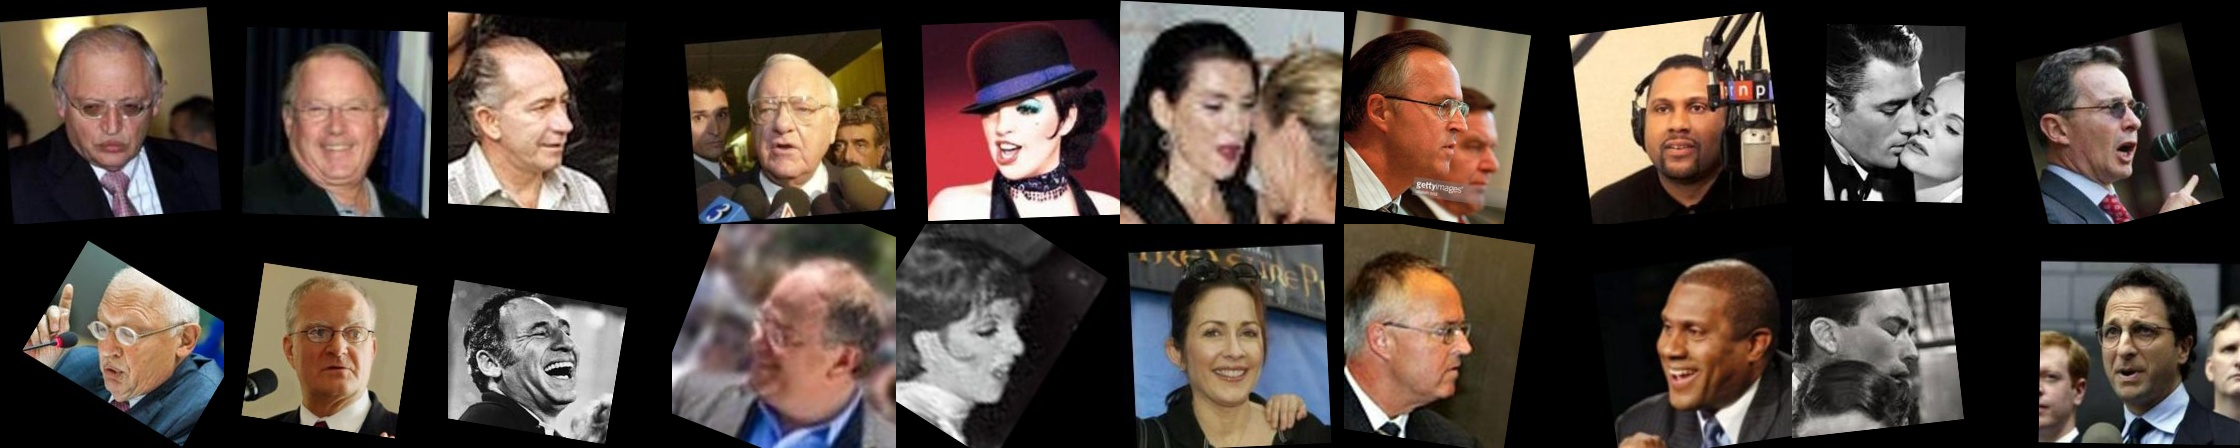

In [ ]:
CPLFW_loader = CPLFW()
image_num = 10

# concatenate image Horizontally
rand_select = np.random.randint(0, len(CPLFW_loader)-1, image_num)
Hori = [np.concatenate((CPLFW_loader[i][0] , CPLFW_loader[i][1]), axis=0) for i in rand_select]
Verti = Hori[0]
for i in range(1,image_num):
  Verti = np.concatenate( (Verti,Hori[i]) , axis = 1 )
from google.colab.patches import cv2_imshow
print([CPLFW_loader.pairs[i] for i in rand_select])
print([CPLFW_loader[i][2] for i in rand_select])
cv2_imshow(Verti)

## Client

In [ ]:
def prepare_to_send(image):
  _, buffer = cv2.imencode('.jpg', image)
  image_as_text = base64.b64encode(buffer).decode('utf-8')
  return image_as_text

def calculate_metrics(predicted, actual):
  """Calculates accuracy, FMR, and FNMR.
  Args:
    predicted: A list of predicted values (True/False).
    actual: A list of actual values (True/False).
  Returns:
    A tuple of (accuracy, FMR, FNMR).
  """
  assert len(predicted) == len(actual), "Predicted and actual lists must have the same length."
  # Calculate True Positives (TP), True Negatives (TN), False Positives (FP), False Negatives (FN)
  TP = sum(p and a for p, a in zip(predicted, actual))
  TN = sum(not p and not a for p, a in zip(predicted, actual))
  FP = sum(p and not a for p, a in zip(predicted, actual))
  FN = sum(not p and a for p, a in zip(predicted, actual))

  # Calculate accuracy, FMR, and FNMR
  accuracy = (TP + TN) / len(predicted)
  FMR = FP / (FP + TN)  # False Match Rate
  FNMR = FN / (FN + TP)  # False Non-Match Rate
  return accuracy, FMR, FNMR

def report(address, model , dataset):
  predicts_list = []
  labels_list = []
  for p in dataset:
    img1 , img2 , label = p
    img1 = prepare_to_send(img1)
    img2 = prepare_to_send(img2)
    response = requests.post(address, json={'img1': img1, 'img2': img2, 'model': model})
    predicts_list.append(response.json()['message'])
    labels_list.append(label)
  accuracy, FMR, FNMR =  calculate_metrics(predicts_list, labels_list)
  clear_output()
  print("####################     {}-{}    ########################".format(dataset.dataset_name,model))
  print(f"Accuracy: {accuracy}")
  print(f"FMR: {FMR}")
  print(f"FNMR: {FNMR}")


## buffalo_l - LFW


In [ ]:
address = " http://"+ip+":6008"+"/predict"
model = "buffalo_l"
loader = LFW()
report(address, model , loader)

####################     LFW-buffalo_l    ########################
Accuracy: 0.987
FMR: 0.0003333333333333333
FNMR: 0.025666666666666667


## buffalo_l - CALFW

In [11]:
address = " http://"+ip+":6008"+"/predict"
model = "buffalo_l"
loader = CALFW()
report(address, model , loader)

####################     CALFW-buffalo_l    ########################
Accuracy: 0.9555
FMR: 0.005666666666666667
FNMR: 0.08333333333333333


## buffalo_l - CPLFW


Due to the current threshold setting, the model is unable to accurately recognize certain images for CPLFW. To improve performance, we would need to adjust the threshold. However, given the time constraint, I am unable to reuse the model at this time. I apologize for any inconvenience this may cause. It effects on metrics.

In [ ]:
img1 , img2 , label = loader[196]
img1 = prepare_to_send(img1)
img2 = prepare_to_send(img2)
response = requests.post(address, json={'img1': img1, 'img2': img2, 'model': model})

<ipython-input-4-fe8010aa47d0>:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(imageS, np.uint8)
INFO:werkzeug:172.28.0.12 - - [03/Dec/2024 21:17:38] "POST /predict HTTP/1.1" 400 -


In [ ]:
address = " http://"+ip+":6008"+"/predict"
model = "buffalo_l"
loader = CPLFW()
report(address, model , loader)

####################     CPLFW-buffalo_l    ########################
Accuracy: 0.9388333333333333
FMR: 0.019666666666666666
FNMR: 0.10266666666666667


## buffalo_s - LFW


In [ ]:
address = " http://"+ip+":6008"+"/predict"
model = "buffalo_s"
loader = LFW()
report(address, model , loader)

####################     LFW-buffalo_s    ########################
Accuracy: 0.9821666666666666
FMR: 0.0016666666666666668
FNMR: 0.034


## buffalo_s - CALFW
Accuracy: 0.93%

FMR: 0.012

FNMR: 0.11

In [ ]:
address = " http://"+ip+":6008"+"/predict"
model = "buffalo_s"
loader = CALFW()
report(address, model , loader)

####################     CALFW-buffalo_s    ########################
Accuracy: 0.9366666666666666
FMR: 0.012333333333333333
FNMR: 0.11433333333333333


## buffalo_s - CPLFW


In [ ]:
address = " http://"+ip+":6008"+"/predict"
model = "buffalo_s"
loader = CPLFW()
report(address, model , loader)

####################     CPLFW-buffalo_s    ########################
Accuracy: 0.8951666666666667
FMR: 0.029666666666666668
FNMR: 0.18


| Model | Dataset | Accuracy | FMR | FNMR |
|---|---|---|---|---|
| buffalo_l | LFW | 98.7% | 0.0003 | 0.0256 |
| buffalo_l | CALFW | 95.5% | 0.005 | 0.083 |
| buffalo_l | CPLFW | 93.8% | 0.0196 | 0.102 |
| buffalo_s | LFW | 98.2% | 0.001 | 0.034 |
| buffalo_s | CALFW | 93.0% | 0.012 | 0.11 |
| buffalo_s | CPLFW | 89.5% | 0.029 | 0.18